In [1]:
import pandas as pd
import xgboost as xgb
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
trn = pd.read_csv("../data/processed/trn.feat.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.feat.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.feat.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.feat.csv")

trn_y, trn_X = trn["Solubility"], trn.drop(["Solubility", "Name", "SMILES"], axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)

In [3]:
tune_space = {
    "eta": hp.choice("eta", [0.01, 0.1, 0.3]),
    "gamma": hp.uniform("gamma", 1, 9),
    "alpha": hp.quniform("alpha", 40, 180, 1),
    "lambda": hp.uniform("lambda", 0, 1),
    "max_depth": hp.randint("max_depth", 6, 10),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",  # ["gbtree", "gblinear", "dart"]
    "eval_metric": "rmse",
    "tree_method": "auto",  # ["auto", "hist", "exact", "approx"]

    "num_boost_round": hp.choice("num_boost_round", [100, 200, 300]),
    "nfold": 5
}

In [4]:
def tune_obj(space):
    eval_history = xgb.cv(
        params={
            "eta": space["eta"],
            "gamma": space["gamma"],
            "alpha": space["alpha"],
            "lambda": space["lambda"],
            "max_depth": space["max_depth"],
            "min_child_weight": space["min_child_weight"],
            "colsample_bytree": space["colsample_bytree"],

            "objective": space["objective"],

            "device": space["device"],
            "booster": space["booster"],
            "eval_metric": space["eval_metric"],
            "tree_method": space["tree_method"]
        },
        dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
        num_boost_round=space["num_boost_round"],
        metrics=space["eval_metric"],
        nfold=space["nfold"]
    )
    return {
        "loss": min(eval_history["test-rmse-mean"]),
        'status': STATUS_OK
    }

In [5]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

100%|██████████| 100/100 [57:03<00:00, 34.23s/trial, best loss: 0.7209120453022697] 


In [6]:
best_params

{'alpha': 40.0,
 'colsample_bytree': 0.7736529640013535,
 'eta': 1,
 'gamma': 1.1475022441592932,
 'lambda': 0.469965504825428,
 'max_depth': 9,
 'min_child_weight': 7.0,
 'num_boost_round': 1}

In [120]:
best_params = {
    "eta": 0.01,
    "gamma": 1.1055210927423804,
    "alpha": 40.0,
    "lambda": 0.7993390441866357,
    "max_depth": 9,
    "min_child_weight": 5.0,
    "colsample_bytree": 0.9960479463691504,

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",

    "num_boost_round": 200,
    "early_stopping_rounds": 10,
    "nfold": 5
}

In [ ]:
xgb.cv(
    params={
        "eta": best_params["eta"],
        "gamma": best_params["gamma"],
        "alpha": best_params["alpha"],
        "lambda": best_params["lambda"],
        "max_depth": best_params["max_depth"],
        "min_child_weight": best_params["min_child_weight"],
        "colsample_bytree": best_params["colsample_bytree"],
        "objective": "reg:squarederror",
        "device": best_params["device"],
        "booster": best_params["booster"],
        "eval_metric": best_params["eval_metric"],
        "tree_method": best_params["tree_method"],
    },
    dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
    num_boost_round=best_params["num_boost_round"],
    nfold=best_params["nfold"],
    metrics=best_params["eval_metric"],
    early_stopping_rounds=best_params["early_stopping_rounds"],
    verbose_eval=True,
)

In [135]:
booster = xgb.train(
    params={
        "eta": best_params["eta"],
        "gamma": best_params["gamma"],
        "alpha": best_params["alpha"],
        "lambda": best_params["lambda"],
        "max_depth": best_params["max_depth"],
        "min_child_weight": best_params["min_child_weight"],
        "colsample_bytree": best_params["colsample_bytree"],
        "objective": "reg:squarederror",
        "device": best_params["device"],
        "booster": best_params["booster"],
        "eval_metric": best_params["eval_metric"],
        "tree_method": best_params["tree_method"],
    },
    dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
    num_boost_round=best_params["num_boost_round"]
)

In [136]:
tst1_19SC_pred = booster.predict(xgb.DMatrix(data=tst1_19SC_X))
tst2_19SC_pred = booster.predict(xgb.DMatrix(data=tst2_19SC_X))
tst_08SC_pred = booster.predict(xgb.DMatrix(data=tst_08SC_X))

In [137]:
performance = {
    "2019SC TST1 (RMSE)": mean_squared_error(tst1_19SC_y.values, tst1_19SC_pred, squared=False),
    "2019SC TST2 (RMSE)": mean_squared_error(tst2_19SC_y.values, tst2_19SC_pred, squared=False),
    "2008SC TST  (RMSE)": mean_squared_error(tst_08SC_y.values, tst_08SC_pred, squared=False),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y.values, tst1_19SC_pred),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y.values, tst2_19SC_pred),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y.values, tst_08SC_pred),
}
performance

{'2019SC TST1 (RMSE)': 0.8089897921992447,
 '2019SC TST2 (RMSE)': 1.3731431447971116,
 '2008SC TST  (RMSE)': 0.8337688218083779,
 '2019SC TST1 (R^2)': 0.4609849351459747,
 '2019SC TST2 (R^2)': 0.5313060766893176,
 '2008SC TST  (R^2)': 0.6225232084374053}

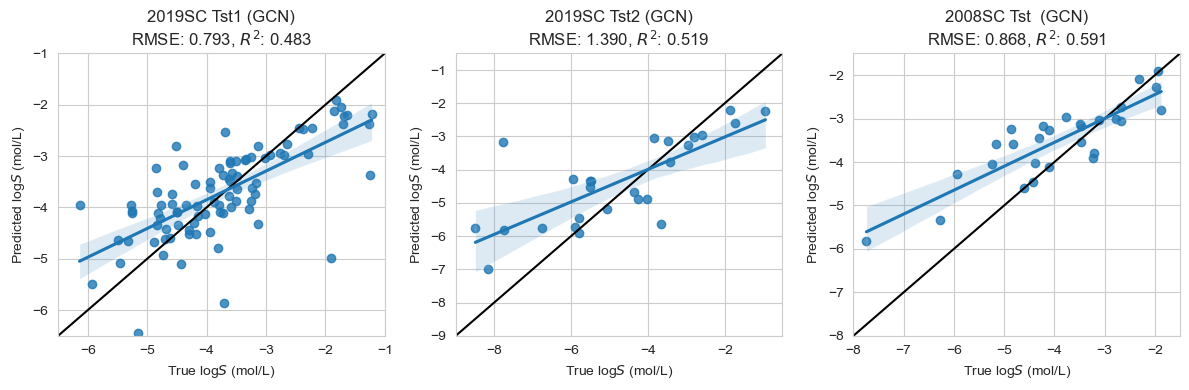

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GCN"
min_ax1, max_ax1 = -6.5, -1
min_ax2, max_ax2 = -9, -0.5
min_ax3, max_ax3 = -8, -1.5

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")
sns.lineplot(x=[min_ax3, max_ax3], y=[min_ax3, max_ax3], ax=ax3, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst1_19SC_y.values,
        "Predicted log$S$ (mol/L)": tst1_19SC_pred
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst2_19SC_y.values,
        "Predicted log$S$ (mol/L)": tst2_19SC_pred
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax2
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst_08SC_y.values,
        "Predicted log$S$ (mol/L)": tst_08SC_pred
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax3
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)
ax3.set_xlim(min_ax3, max_ax3)
ax3.set_ylim(min_ax3, max_ax3)

ax1.set_title(f"2019SC Tst1 ({model_name})\n"
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"2019SC Tst2 ({model_name})\n"
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"2008SC Tst  ({model_name})\n"
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

# plt.axis("equal")
plt.tight_layout()